In [28]:
from numpy import genfromtxt
float_data = genfromtxt('datasets/jena_climate_2009_2016.csv', delimiter=',', skip_header=True, usecols=(range(1,15)))
print float_data.shape

(420551, 14)


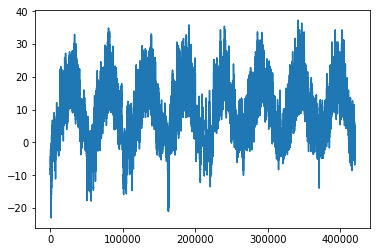

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

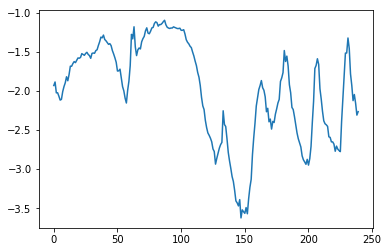

In [25]:
plt.plot(range(240), temp[:240])
plt.show()

In [29]:
mean = float_data[:200000].mean(axis=0)
normalized_data = float_data - mean
std = normalized_data[:200000].std(axis=0)
centered_data = normalized_data / std

In [7]:
def generate_data(data, lookback, delay):
    max_index = len(data) - delay - 1
    x = np.zeros((max_index-lookback, lookback, 14)).astype(np.float64)
    y = np.zeros((max_index-lookback)).astype(np.float64)
    for i in range(0+lookback, max_index):
        x[i-lookback] = data[i-lookback:i]
        y[i-lookback] = data[i+delay][1]
    return x,y

In [8]:
step = 6 # = 1 Datenpunkt pro Stunde
lookback = 240 # = 5 Tage = 5 * 24 Stunden
delay = 24 # = 1 Tag in die Zukunft vorhersagen
max_index = len(centered_data) - delay - 1
subsampled = centered_data[::step, :]

In [10]:
import numpy as np
# Datenset: x_shape = [-1, 120, 14]
training_data = subsampled[:43800, :]
train_x, train_y = generate_data(training_data, lookback, delay)

val_data = subsampled[43800:52560]
val_x, val_y = generate_data(val_data, lookback, delay)

test_data = subsampled[52560:, :]
test_x, test_y = generate_data(test_data, lookback, delay)

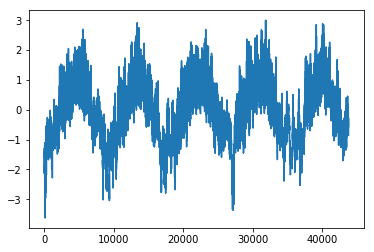

In [13]:
temp = training_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

In [15]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.GRU(16,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=False,
                     input_shape=(None, centered_data.shape[-1])))
model.add(keras.layers.GRU(32, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae', metrics=[keras.metrics.mean_absolute_error])

/Users/markkeinhorster/.venv/tf_weather_service/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
model = keras.models.load_model("keras_models/jena_temp_pred.h5")

In [17]:
evals = model.evaluate(x=test_x, y=test_y)
print evals

17267/17267 [==============================] - 18s 1ms/step
[1.5554035699498006, 1.5554035699498006]


In [22]:
pred = model.predict(test_x)
print pred.shape

(17267, 1)


In [30]:
index = 10110
point = model.predict(test_x[index:index+1])
print "pred=%f, target=%f, mean=%f, std=%f" % (point[0,0]*std[1]+mean[1], test_y[index]*std[1]+mean[1], mean[1], std[1])
print point.shape

pred=5.044016, target=7.990000, mean=9.077349, std=8.852499
(1, 1)


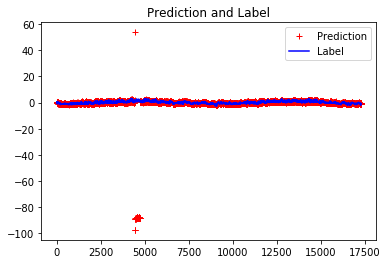

In [27]:
epochs = range(len(pred))
plt.figure()
plt.plot(epochs, pred, 'r+', label='Prediction')
plt.plot(epochs, test_y, 'b-', label='Label')
plt.title('Prediction and Label')
plt.legend()

plt.show()